In [1]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
from matplotlib import pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors

In [2]:
# define sbj: HC or EOS
sbj='HC' # 91 subjects for HC and 82 for EOS
# define feature: FC, SC, MSC
feature='FC'

In [3]:
pathlist='/media/shuang/data/BrainAge/Brain_age_scripts/lists'
filename='commonList_'+sbj+'.txt'
pathdata='/media/shuang/data/BrainAge/Brain_age_scripts/common_features'
dataname='common_'+feature+'_'+sbj+'.mat'

In [4]:
# Load subject lists
with open(os.path.join(pathlist,filename), 'r', encoding='utf-8') as f:
    temp_subj_list = f.readlines()
subj_list = [item.replace('\n', '') for item in temp_subj_list]

In [12]:
# Load Glasser 360 connectome data
Data = sio.loadmat(os.path.join(pathdata,dataname))
vari_name = 'common_'+feature+'_'+sbj
Data = np.array(Data[vari_name]) # subjects*360*360

In [13]:
# Load region indices
region_id = sio.loadmat('/media/shuang/data/BrainAge/Brain_age_scripts/template/N22index.mat')['N22']
# Find unique cluster IDs
cluster_id = np.unique(region_id)
num_clusters = len(cluster_id)

In [33]:
# Find network index
new_index = np.zeros(360)
numbers = np.zeros((num_clusters, 2))
j = 0
for i, cluster in enumerate(cluster_id):
    moduel_index = np.where(region_id[:, 0] == cluster)[0]
    temp = len(moduel_index)
    new_index[j:j + temp] = moduel_index
    j += temp
    numbers[i] = [cluster, temp]
new_index = new_index.astype(int)

In [185]:
# Down-sample
group_data = np.zeros((360, 360))
IC_data = np.zeros((Data.shape[0] + 2, len(cluster_id))) # within-network
EC_data = np.zeros((Data.shape[0] + 2, int(len(cluster_id) * (len(cluster_id) - 1) / 2))) # between-network
for subj_id in range(Data.shape[0]):
    print("subj", subj_list[subj_id], "processing..........")
    data = Data[subj_id, :, :]
    data = np.array(data)
    data = data[new_index, :]
    data = data[:, new_index]# reshaped data according to network index
    group_data += data
    ## extracting within- & between-network features
    IC = np.zeros((num_clusters, 2))
    EC = np.zeros((num_clusters * (num_clusters - 1) // 2, 3))
    start = 0
    nn = 0
    record_mask = np.zeros((360, 360))
    for i in range(num_clusters):
        cluster_index = numbers[i, 0]
        cluster_size = int(numbers[i, 1])
        module_value = data[start:start + cluster_size, start:start + cluster_size]
        # create a mask to exclude diagonal elements
        mask1 = np.ones_like(module_value, dtype=bool)
        np.fill_diagonal(mask1, False)
        # calculate mean
        mean_val = np.mean(module_value[mask1])
        IC[i, :] = [cluster_index, mean_val]
        record_mask[start:start + cluster_size, start:start + cluster_size] = (i + 1) * 10
        temp = 0
        if i > 0:
            for j in range(i):
                mask2 = np.zeros_like(data, dtype=bool)
                cluster_size2 = int(numbers[j, 1])
                mask2[start:start + cluster_size, temp:temp + cluster_size2] = True
                # print(j, ' x: (', start, ',', start + cluster_size, ') y: (', temp, ',', temp + cluster_size2, ')', 'up: ', cluster_size2, 'cur: ', cluster_size)
                module_value = data[mask2]
                EC[nn, :] = [numbers[i, 0], numbers[j, 0], np.mean(module_value)]
                record_mask[start:start + cluster_size, temp:temp + cluster_size2] = (i+1)*10 + (j+1)
                temp += cluster_size2
                nn += 1
        start += cluster_size
    IC_data[subj_id + 2, :] = IC[:, 1]
    EC_data[subj_id + 2, :] = EC[:, 2]
    IC_data[0, :] = IC[:, 0]
    IC_data[1, :] = IC[:, 0]
    EC_data[0, :] = EC[:, 0]
    EC_data[1, :] = EC[:, 1]
    print("subj", subj_list[subj_id], "finished")

subj SCON003 processing..........
subj SCON003 finished
subj SCON004 processing..........
subj SCON004 finished
subj SCON005 processing..........
subj SCON005 finished
subj SCON006 processing..........
subj SCON006 finished
subj SCON007 processing..........
subj SCON007 finished
subj SCON008 processing..........
subj SCON008 finished
subj SCON010 processing..........
subj SCON010 finished
subj SCON013 processing..........
subj SCON013 finished
subj SCON014 processing..........
subj SCON014 finished
subj SCON015 processing..........
subj SCON015 finished
subj SCON017 processing..........
subj SCON017 finished
subj SCON018 processing..........
subj SCON018 finished
subj SCON019 processing..........
subj SCON019 finished
subj SCON020 processing..........
subj SCON020 finished
subj SCON022 processing..........
subj SCON022 finished
subj SCON023 processing..........
subj SCON023 finished
subj SCON025 processing..........
subj SCON025 finished
subj SCON026 processing..........
subj SCON026 f

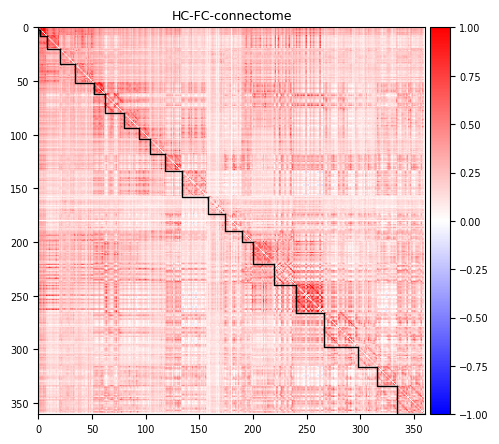

In [187]:
# plot group connectivity matrix
plt.rcParams.update({"font.size": 7})#
#x=plt.title("validation_acc",fontsize=20)
plt.rcParams['figure.figsize'] = (5, 5)
ax = plt.gca()
# For SC
#im = plt.imshow(np.array(group_data), cmap='bwr',clim=[-0.7, 0.7]) 

# For FC
im = plt.imshow(np.array(group_data), cmap='bwr',clim=[-1, 1])

# For MSN
#im = plt.imshow(np.array(group_data), cmap='bwr', norm=mcolors.TwoSlopeNorm(vmin=data.min(), vmax=data.max(), vcenter=0),clim=[-1, 1])
x = 0.5
for j in range(num_clusters):
    LineX = [x-0.5, x-0.5, x + numbers[j, 1] - 0.5]
    LineY = [x - 0.5, x + numbers[j, 1] - 0.5, x + numbers[j, 1] - 0.5]
    x = numbers[j, 1] + x
    #plt.plot(LineX, LineY, 'w', lw=1) # for SC:hot
    plt.plot(LineX, LineY, 'k', lw=1)
plt.title(sbj +'-'+ feature + '-connectome', fontsize=9)
plt.xlim(0, 360.5)
plt.ylim(360.5, 0)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.tight_layout()
#plt.savefig('/media/shuang/data/BrainAge/Glasser360/figures/'+sbj+feature+'groupmatrix.svg', format="svg",dpi=1000)

In [188]:
# # save data
new_data = np.concatenate((IC_data, EC_data), axis=1)
save_data = pd.DataFrame(new_data)
outputpath='/media/shuang/data/BrainAge/Brain_age_scripts/network_features'
outputname=feature+'_'+sbj+'_mean.csv'
save_data.to_csv(os.path.join(outputpath,outputname), index=False, header=False)